# Outcome Prediction with RGCN Model

## 1. Load data from "processed_data"

In [1]:
import time
import math
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn.functional as F
from torch.nn import Parameter, Linear

from torch_geometric.data import Data
from torch_geometric.logging import log
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import to_undirected

In [2]:
num_patients = 1000
inverse_triples=True
embed_dim = 100

entity = pd.read_csv(f'processed_data/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', header=None)
entity = entity.set_index(entity[0])
entity = entity.to_dict()[1]

indices = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    indices.append(entity[idx])

events = pd.read_csv(f'processed_data/sphn_events_{num_patients}_noOutcome.tsv', sep='\t', header=None)
if inverse_triples == True:
    events_inv = events[[2, 1, 0]]
    events_inv.columns=[0,1,2]
    events_inv[1] += events[1].max() + 1
    events = pd.concat((events, events_inv), axis=0)
    events = events.reset_index()
y = joblib.load(f'../Data Generation/outcomes_{num_patients}_0.joblib')
num_x = torch.Tensor(np.load(f'processed_data/sphn_numeric_{num_patients}.npy'))

non_test_X, test_X, non_test_y, test_y_ = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)
train_X, valid_X, train_y_, valid_y_ = train_test_split(non_test_X, non_test_y, stratify=non_test_y, test_size=1./9)

edge_index = torch.vstack((torch.Tensor(events[0]).long(),torch.Tensor(events[2]).long()))
edge_type = torch.Tensor(events[1]).long()
train_idx = torch.Tensor(train_X).long()
train_y = torch.Tensor(train_y_).long()
valid_idx = torch.Tensor(valid_X).long()
valid_y = torch.Tensor(valid_y_).long()
test_idx = torch.Tensor(test_X).long()
test_y = torch.Tensor(test_y_).long()
num_nodes = len(entity)

data = Data(
    edge_index=edge_index,
    edge_type=edge_type,
    train_idx=train_idx,
    train_y=train_y,
    valid_idx=valid_idx,
    valid_y=valid_y,
    test_idx=test_idx,
    test_y=test_y,
    num_nodes=num_nodes,
)
embedding = Parameter(torch.empty(num_nodes, embed_dim))
torch.nn.init.xavier_uniform_(embedding, gain=math.sqrt(2.0))
data.x = embedding
data.num_x = num_x.view(-1,1)
data.num_relations = data.num_edge_types
data.num_classes = 3
print(data)

Data(edge_index=[2, 207200], edge_type=[207200], train_idx=[800], train_y=[800], valid_idx=[100], valid_y=[100], test_idx=[100], test_y=[100], num_nodes=29952, x=[29952, 100], num_x=[29952, 1], num_relations=18, num_classes=3)


## 2. Training the model

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_lin = Linear(1, embed_dim)
        self.conv1 = RGCNConv(embed_dim, 32, data.num_relations,
                          num_bases=8)
        self.conv2 = RGCNConv(32, 32, data.num_relations,
                          num_bases=8)
        # self.conv3 = RGCNConv(16, 16, data.num_relations,
        #                   num_bases=4)
        self.conv4 = RGCNConv(32, data.num_classes, data.num_relations,
                          num_bases=8)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.num_lin(data.num_x))
        x = x + data.x
        x = F.relu(self.conv1(data.x, edge_index, edge_type))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_type))
        x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv3(x, edge_index, edge_type))
        # x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    val_acc = float((pred[data.valid_idx] == data.valid_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, val_acc, test_acc

times = []
best_val_acc = final_test_acc = 0
for epoch in range(1, 501):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        torch.save(model.state_dict(), f'processed_data/model_weights_rgcn_{num_patients}.pth')
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 1.0948, Train: 0.4300, Val: 0.4100, Test: 0.4000
Epoch: 002, Loss: 1.0869, Train: 0.4363, Val: 0.4100, Test: 0.4000
Epoch: 003, Loss: 1.0816, Train: 0.4475, Val: 0.4100, Test: 0.4000
Epoch: 004, Loss: 1.0751, Train: 0.4562, Val: 0.4200, Test: 0.4100
Epoch: 005, Loss: 1.0682, Train: 0.4575, Val: 0.4100, Test: 0.4100
Epoch: 006, Loss: 1.0610, Train: 0.4612, Val: 0.4300, Test: 0.4200
Epoch: 007, Loss: 1.0552, Train: 0.4562, Val: 0.4200, Test: 0.4200
Epoch: 008, Loss: 1.0474, Train: 0.4575, Val: 0.4200, Test: 0.4200
Epoch: 009, Loss: 1.0404, Train: 0.4512, Val: 0.4400, Test: 0.4400
Epoch: 010, Loss: 1.0341, Train: 0.4512, Val: 0.4400, Test: 0.4400
Epoch: 011, Loss: 1.0278, Train: 0.4512, Val: 0.4400, Test: 0.4400
Epoch: 012, Loss: 1.0206, Train: 0.4450, Val: 0.4400, Test: 0.4400
Epoch: 013, Loss: 1.0131, Train: 0.4475, Val: 0.4200, Test: 0.4400
Epoch: 014, Loss: 1.0081, Train: 0.4450, Val: 0.4200, Test: 0.4400
Epoch: 015, Loss: 1.0021, Train: 0.4450, Val: 0.4200, Test: 0.

## 3. Results - AUC / Confusion matrix / TSNE visualization

In [4]:
from sklearn.metrics import roc_auc_score

model = Net().to(device)
model.load_state_dict(torch.load(f'processed_data/model_weights_rgcn_{num_patients}.pth', weights_only=True))
model.eval()
with torch.no_grad():
    out = model(data.edge_index, data.edge_type).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(data.test_y.cpu(), prob[data.test_idx.cpu()], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')

ROC AUC score: 0.8806


0
0    44
1    43
2    13
Name: count, dtype: int64


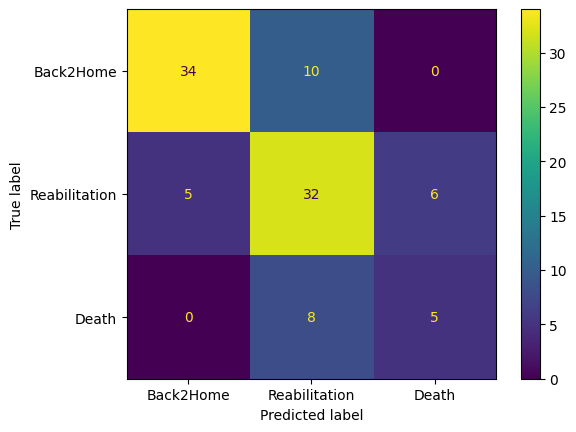

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(pd.DataFrame(test_y.cpu()).value_counts())

model.eval()
pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
matrix = confusion_matrix(data.test_y.cpu(), pred[data.test_idx].cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()

tensor([[ 0.2801,  0.1467,  0.1770,  ...,  0.2438,  0.3043,  0.1463],
        [ 0.0966,  0.0159, -0.0460,  ...,  0.0322,  0.1231, -0.0556],
        [ 0.2710,  0.0550,  0.0784,  ...,  0.1591,  0.2173,  0.0905],
        ...,
        [ 0.4534,  0.3297,  0.4151,  ...,  0.4273,  0.6358,  0.4487],
        [ 0.6181,  0.3714,  0.4349,  ...,  0.5272,  0.7158,  0.6105],
        [ 0.5727,  0.2175,  0.2968,  ...,  0.4723,  0.6448,  0.4108]],
       device='cuda:0')


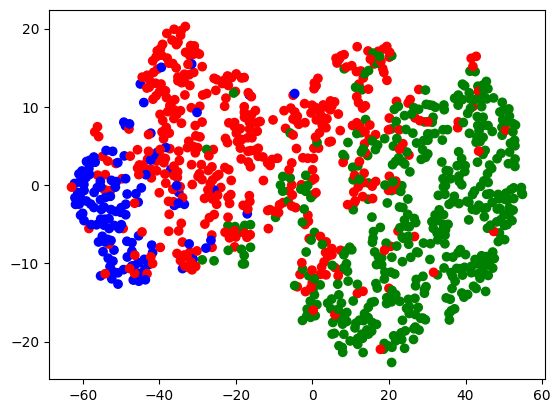

In [6]:
# TSNE visualization of Conv2 layer.
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
output = model(data.edge_index, data.edge_type)
out = activation['conv2']
print(out)

out_patient = out[indices].cpu().numpy()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30) # perplexity 5 ~ 50
patient_tsne = tsne.fit_transform(out_patient)

colors = [['g', 'r', 'b'][i] for i in y]
plt.scatter(patient_tsne[:,0], patient_tsne[:,1], c=colors)
plt.show()